In [1]:
import torch
import ultralytics
ultralytics.checks()
from ultralytics import YOLO
import os
import supervision as sv
import shutil
import yaml
import pandas as pd
import random
from collections import defaultdict
import matplotlib.pyplot as plt
import glob
import seaborn as sns
import cv2
from PIL import Image
import math

Ultralytics YOLOv8.0.117  Python-3.9.16 torch-2.0.0+cu118 CUDA:0 (NVIDIA GeForce RTX 3090, 24575MiB)
Setup complete  (12 CPUs, 31.9 GB RAM, 606.2/930.9 GB disk)


In [19]:
# file_path 경로에 _gether폴더 생성
file_path = "./datasets/OOA_Data_v9/"
_gether  = "gether/"
_generated = "generated/"
_generated2 = "generated2/"
_test = "test/"
_train = "train/"
_valid = "valid/"
_test2 = "test2/"
_train2 = "train2/"
_valid2 = "valid2/"
_images = "images/"
_labels = "labels/"

gether_path = os.path.join(file_path, _gether)
gether_img_path = os.path.join(gether_path, _images)
gether_label_path = os.path.join(gether_path, _labels)

generated_path = os.path.join(file_path, _generated)
generated2_path = os.path.join(file_path, _generated2)
generated_img_path = os.path.join(generated_path, _images)
generated2_img_path = os.path.join(generated2_path, _images)
generated_label_path = os.path.join(generated_path, _labels)
generated2_label_path = os.path.join(generated2_path, _labels)

target_test_folder = os.path.join(file_path, _test2)
target_train_folder = os.path.join(file_path, _train2)
target_valid_folder = os.path.join(file_path, _valid2)

target_test_img_folder = os.path.join(target_test_folder, _images)
target_train_img_folder = os.path.join(target_train_folder, _images)
target_valid_img_folder = os.path.join(target_valid_folder, _images)

target_test_label_folder = os.path.join(target_test_folder, _labels)
target_train_label_folder = os.path.join(target_train_folder, _labels)
target_valid_label_folder = os.path.join(target_valid_folder, _labels)

random_seed = 42

In [12]:
def create_folder(folder_path):
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
        print( folder_path + " : CREATED!")
    else:
        print( folder_path + " : EXISTS!")

def create_folders():
    create_folder(gether_path)
    create_folder(gether_img_path)
    create_folder(gether_label_path)
    
    create_folder(target_test_folder)
    create_folder(target_train_folder)
    create_folder(target_valid_folder)
    
    create_folder(target_test_img_folder)
    create_folder(target_train_img_folder)
    create_folder(target_valid_img_folder)
    
    create_folder(target_test_label_folder)
    create_folder(target_train_label_folder)
    create_folder(target_valid_label_folder)
    
    

# 폴더 통합 
def gether_to_onefolder(file_path):
    folders = []
    folders.append(os.path.join(file_path, _test))
    folders.append(os.path.join(file_path, _train))
    folders.append(os.path.join(file_path, _valid))
    
    # 이미지, 텍스트 복사 이동
    for folder in folders:
        img_folder = os.path.join(folder, _images)
        img_files = os.listdir(img_folder)
        for img_file in img_files:
            img_src = os.path.join(img_folder, img_file)
            img_dst = os.path.join(gether_img_path, img_file)
            # img_src 폴더에서 img_dst폴더로
            if not os.path.exists(img_dst):
                shutil.copy(img_src, img_dst)
            
        lab_folder = os.path.join(folder, _labels)
        lab_files = os.listdir(lab_folder)
        for lab_file in lab_files:
            lab_src = os.path.join(lab_folder, lab_file)
            lab_dst = os.path.join(gether_label_path, lab_file)
            # img_src 폴더에서 img_dst폴더로
            if not os.path.exists(lab_dst):
                shutil.copy(lab_src, lab_dst)
                
# yaml 파일에서 names 반환
def get_yaml_names(file_path):
    # YAML 파일 열기
    with open(file_path, 'r') as file:
        # YAML 데이터 로드
        data = yaml.safe_load(file)

    # names 값 가져오기
    return data['names']

# 전체 class별 숫자 반환
def Get_numbers_count(names, label_folder_path):
    numbers_count = {}  # 숫자별 개수를 저장할 딕셔너리 초기화

    # gether_img_path 경로의 텍스트 파일들 순회
    for filename in os.listdir(label_folder_path):
        _path = os.path.join(label_folder_path, filename)
        
        # 텍스트 파일 열기
        with open(_path, 'r') as file:
            lines = file.readlines()
        
        # 각 줄에서 첫 번째 숫자 추출하여 개수 세기
        for line in lines:
            number = line.split()[0]
            numbers_count[number] = numbers_count.get(number, 0) + 1
    
    df = pd.DataFrame(numbers_count.items(), columns=['Class_id', 'Count'])
    
    # 열을 숫자형으로 변환
    df['Class_id'] = df['Class_id'].astype(int)
    df['Count'] = df['Count'].astype(int)

    # Name 컬럼 생성 ( Class_id로 부터 )
    df['Name'] = [names[number] for number in df['Class_id']]

    # Class_id 정렬
    df = df.sort_values('Class_id', ascending=True)
    
    return df

# input 
#   gether_label_path : 라벨을 모으고 싶은 폴더 경로
# return 
#   pd.dataframe
# 파일별로 포함된 class_id 반환
def get_numbers_each_file(gether_label_path):
    data = []

    # gether_label_path 폴더 내의 텍스트 파일들 순회
    for filename in os.listdir(gether_label_path):
        file_path = os.path.join(gether_label_path, filename)
        
        # 파일명
        file_name = filename
        
        # 파일 내용
        with open(file_path, 'r') as file:
            lines = file.readlines()
        
        # 파일 내용에서 Number 추출
        numbers = []
        for line in lines:
            number = int(line.split()[0])
            numbers.append(number)
        
        # 데이터 추가
        data.append({'file_name': file_name, 'Numbers': numbers})

    # 데이터프레임 생성
    df = pd.DataFrame(data)
    return df

# 
def divide_txt_files(source_folder, target_folder_1, target_folder_2, target_folder_3, ratio_1, ratio_2, ratio_3, random_seed=42):
    assert ratio_1 + ratio_2 + ratio_3 == 1, "비율 합은 1이어야 합니다."

    if random_seed is not None:
        random.seed(random_seed)

    
    # 폴더 체크
    os.makedirs(target_folder_1, exist_ok=True)
    os.makedirs(target_folder_2, exist_ok=True)
    os.makedirs(target_folder_3, exist_ok=True)

    # 초기화
    counts = defaultdict(lambda: [0, 0, 0])  

    # 파일별 번호 리스트 생성 및 셔플
    df = get_numbers_each_file(source_folder)
    df = df.sample(frac=1, random_state=random_seed)

    for _, row in df.iterrows():
        # 파일이름, class_id(Numbers) 
        file_name, numbers = row["file_name"], row["Numbers"]
        source_file_path = os.path.join(source_folder, file_name)

        # 파일 유무 체크
        if not os.path.isfile(source_file_path):
            print(f"{file_name} : 존재하지 않는 파일입니다.")
            continue

        # 이동할 폴더 설정
        for number in sorted(numbers):
            current_counts = counts[number]
            total = sum(current_counts)
            if total == 0 or (current_counts[0] / total < ratio_1):
                target_folder = target_folder_1
                counts[number][0] += 1
            elif current_counts[1] / total < ratio_2:
                target_folder = target_folder_2
                counts[number][1] += 1
            else:
                target_folder = target_folder_3
                counts[number][2] += 1

            # 대상폴더에 파일 복사
            target_file_path = os.path.join(target_folder, file_name)
            shutil.copy(source_file_path, target_file_path)

            break
      
# 이동된 텍스트 파일 위치에 맞는 폴더로 이미지 파일 복사  
def divide_img_files(source_folder, label_folder, target_folder):
    # 폴더 체크
    os.makedirs(target_folder, exist_ok=True)

    # 파일명 리스트 가져오기
    label_files = [os.path.splitext(file)[0] for file in os.listdir(label_folder)]

    # 소스 폴더에서 파일명 가져오기
    for file_name in os.listdir(source_folder):
        # 확장자 제거
        file_name_without_ext = os.path.splitext(file_name)[0]

        # 해당 위치로 이미지 파일 복사
        if file_name_without_ext in label_files:
            source_file_path = os.path.join(source_folder, file_name)
            target_file_path = os.path.join(target_folder, file_name)
            shutil.copy(source_file_path, target_file_path)
            

names = get_yaml_names(os.path.join(file_path, 'data.yaml'))

In [4]:
create_folders()

./datasets/OOA_Data_v9/gether/ : EXISTS!
./datasets/OOA_Data_v9/gether/images/ : EXISTS!
./datasets/OOA_Data_v9/gether/labels/ : EXISTS!
./datasets/OOA_Data_v9/test2/ : CREATED!
./datasets/OOA_Data_v9/train2/ : CREATED!
./datasets/OOA_Data_v9/valid2/ : CREATED!
./datasets/OOA_Data_v9/test2/images/ : CREATED!
./datasets/OOA_Data_v9/train2/images/ : CREATED!
./datasets/OOA_Data_v9/valid2/images/ : CREATED!
./datasets/OOA_Data_v9/test2/labels/ : CREATED!
./datasets/OOA_Data_v9/train2/labels/ : CREATED!
./datasets/OOA_Data_v9/valid2/labels/ : CREATED!


In [103]:
### 데이터 준비 , 사전작업
# 폴더 생성, 폴더 합치기
create_folders()
gether_to_onefolder(file_path)

./datasets/OOA_Data_v13/gether/ Folder already exists.
./datasets/OOA_Data_v13/gether/images/ Folder already exists.
./datasets/OOA_Data_v13/gether/labels/ Folder already exists.
./datasets/OOA_Data_v13/test2/ Folder already exists.
./datasets/OOA_Data_v13/train2/ Folder already exists.
./datasets/OOA_Data_v13/valid2/ Folder already exists.
./datasets/OOA_Data_v13/test2/images/ Folder already exists.
./datasets/OOA_Data_v13/train2/images/ Folder already exists.
./datasets/OOA_Data_v13/valid2/images/ Folder already exists.
./datasets/OOA_Data_v13/test2/labels/ Folder already exists.
./datasets/OOA_Data_v13/train2/labels/ Folder already exists.
./datasets/OOA_Data_v13/valid2/labels/ Folder already exists.


In [11]:
# 
def print_count_each_names(lable_path, is_show_plot = True):
    model = YOLO('./runs/detect/train7/weights/best.pt')  
    # 모델에서 이름 (names) 리스트 가져오기
    names = model.names
    # Create a dictionary to store counts of each name
    name_counts = {name: 0 for name in names.values()}

    # 파일명 리스트 가져오기
    label_files = [os.path.join(lable_path, file) for file in os.listdir(lable_path)]

    # Loop through each text file
    for txt_file in label_files:
        with open(txt_file, 'r') as f:
            # Read the file and split it into lines
            lines = f.read().splitlines()

            # For each line, increment the count of the corresponding name
            for line in lines:
                # Get the first number in the line, which is the key to the name
                key = int(line.split()[0])

                # Check if the key exists in the names dictionary
                if key in names:
                    name_counts[names[key]] += 1
    df = pd.DataFrame(list(name_counts.items()), columns=['Name', 'Count'])
    df = df.sort_values('Count', ascending=False)
    if is_show_plot:
        show_plot(df)
    return df

# 바 플롯 그리기
def show_plot(df):
    # 이름과 개수를 분리
    plt.figure(figsize=(15,8)) # 그래프 크기 설정
    sns.barplot(x=df['Name'], y=df['Count'], palette='viridis') 

    plt.title('Name Counts')
    plt.xlabel('Names')
    plt.ylabel('Counts')

    plt.xticks(rotation=90) # x축 레이블 회전
    plt.show()

In [13]:
def resize_images(from_path, to_path, set_size=(640, 640)):
    """
    Parameters:
    from_path (str): 복제될 images와 lagels 폴더의 상위 폴더
    to_path (str): 복제된 images와 labels 폴더의 상위 폴더
    set_size (int, int) : default (640, 640), 변경될 이미지 사이즈
    Returns:
    None
    """
    global _images, _labels
    from_img_path = os.path.join(from_path, _images)
    from_label_path = os.path.join(from_path, _labels)
    to_img_path = os.path.join(to_path, _images)
    to_label_path = os.path.join(to_path, _labels)
    
    # 폴더 체크
    os.makedirs(from_img_path, exist_ok=True)
    os.makedirs(from_label_path, exist_ok=True)
    os.makedirs(to_img_path, exist_ok=True)
    os.makedirs(to_label_path, exist_ok=True)

    # 이미지 및 레이블 디렉토리에서 각 파일 복사
    for filename in os.listdir(from_img_path):
        if filename.endswith('.jpg') or filename.endswith('.png'):  # 이미지 파일인 경우
            if from_path != to_path:
                # 이미지 파일 복사
                shutil.copy2(os.path.join(from_img_path, filename), to_img_path)
                
            # 이미지 열기
            img = Image.open(os.path.join(to_img_path, filename))
            
            # 이미지 크기 변경 (비율 유지)
            img.thumbnail(set_size)
            
            # 변경된 이미지 저장 (원본 이미지를 덮어씀)
            img.save(os.path.join(to_img_path, filename))

    # labels 폴더의 파일들을 그대로 복사
    if from_path != to_path:
        for filename in os.listdir(from_label_path):
            shutil.copy2(os.path.join(from_label_path, filename), to_label_path)
            
def grayscale_images(from_path, to_path):
    """
    from_path 경로 내의 'images'폴더에서 데이터를 불러와 그레이스케일 처리한 후 
    to_path 경로 내의 'images'폴더에 데이터를 저장합니다. 'labels' 폴더의 데이터는 그대로 복제됩니다.
    Parameters:
    from_path (str): 복제될 images와 lagels 폴더의 상위 폴더
    to_path (str): 복제된 images와 labels 폴더의 상위 폴더
    Returns:
    None
    """
    global _images, _labels
    from_img_path = os.path.join(from_path, _images)
    from_label_path = os.path.join(from_path, _labels)
    to_img_path = os.path.join(to_path, _images)
    to_label_path = os.path.join(to_path, _labels)
    
    # 폴더 체크
    os.makedirs(from_img_path, exist_ok=True)
    os.makedirs(from_label_path, exist_ok=True)
    os.makedirs(to_img_path, exist_ok=True)
    os.makedirs(to_label_path, exist_ok=True)

    # from_path 와 to_path 가 같다면 이미지를 수정만 하고, 다르다면 이미지를 복사 후 수정합니다.
    for filename in os.listdir(from_img_path):
        if filename.endswith('.jpg') or filename.endswith('.png'):  # 이미지 파일인 경우
            if from_path != to_path:  # 경로가 다른 경우에만 파일 복사
                shutil.copy2(os.path.join(from_img_path, filename), to_img_path)
            
            # 이미지 열기
            img = Image.open(os.path.join(to_img_path, filename))
            
            # 그레이스케일 적용
            img_gray = img.convert('L')
            
            # 변경된 이미지 저장 (원본 이미지를 덮어씀)
            img_gray.save(os.path.join(to_img_path, filename))

    # labels 폴더의 파일들을 그대로 복사
    if from_path != to_path:  # 경로가 다른 경우에만 파일 복사
        for filename in os.listdir(from_label_path):
            shutil.copy2(os.path.join(from_label_path, filename), to_label_path)
            
# 이미지 & 텍스트 좌우반전 생성
def flip_side_images(from_path, to_path, ratio=0.5):
    """
    from_path 경로 내의 'images'폴더에서 데이터를 불러와 좌우반전한 데이터를 to_path 경로에 
    파일 명 앞에 's_'를 추가하여 저장합니다. ratio (r <= 1) 비율만큼 변경합니다.
    Parameters:
    from_path (str): 복제될 images와 lagels 폴더의 상위 폴더
    to_path (str): 복제된 images와 labels 폴더의 상위 폴더
    ratio (float): 폴더내 변경될 이미지 비율
    Returns:
    None
    """
    global _images, _labels
    from_img_path = os.path.join(from_path, _images)
    from_label_path = os.path.join(from_path, _labels)
    to_img_path = os.path.join(to_path, _images)
    to_label_path = os.path.join(to_path, _labels)
    
    # 폴더 체크
    os.makedirs(from_img_path, exist_ok=True)
    os.makedirs(from_label_path, exist_ok=True)
    os.makedirs(to_img_path, exist_ok=True)
    os.makedirs(to_label_path, exist_ok=True)
    
    # 이미지 폴더에서 파일 목록을 가져오기
    img_files = os.listdir(from_img_path)
    
    # 주어진 비율에 따라 랜덤하게 선택
    selected_files = random.sample(img_files, int(len(img_files) * ratio))
    
    for filename in selected_files:
        # 파일명에서 확장자를 제외하고, 's_'로 시작하지 않는 경우만 처리
        if not filename.startswith('s_'):
            base_filename, ext = os.path.splitext(filename)
            if ext in ['.jpg', '.png']:
                img_path = os.path.join(from_img_path, filename)

                # 이미지를 열고 좌우 반전
                img = Image.open(img_path)
                flipped_img = img.transpose(Image.FLIP_LEFT_RIGHT)
                
                # 이름 앞에 's_'를 붙여서 저장
                flipped_img_path = os.path.join(to_img_path, 's_' + filename)
                flipped_img.save(flipped_img_path)

                # 텍스트 레이블 복사하고 이름, 내용 변경
                label_path = os.path.join(from_label_path, base_filename + '.txt')
                flipped_label_path = os.path.join(to_label_path, 's_' + base_filename + '.txt')
                with open(label_path, 'r') as f:
                    lines = f.readlines()

                with open(flipped_label_path, 'w') as f:
                    for line in lines:
                        # 좌우 반전 & 저장
                        class_id, mid_x, mid_y, point_x, point_y = line.split()
                        mid_x_flip = 1.0 - float(mid_x)  # x 좌표를 반전
                        point_x_flip = 1.0 - float(point_x)  # x 좌표를 반전
                        f.write(f'{class_id} {mid_x_flip} {mid_y} {point_x_flip} {point_y}\n')
                           
                           

                            
def draw_outline_images(from_path, to_path, ratio=0.5):
    """
    from_path 경로 내의 'images'폴더에서 데이터를 불러와 아웃라인만 남긴 이미지 데이터를 
    to_path 경로에 파일 명 앞에 'o_'를 추가하여 저장합니다. ratio (r <= 1) 비율만큼 변경합니다.
    Parameters:
    from_path (str): 복제될 images와 labels 폴더의 상위 폴더
    to_path (str): 복제된 images와 labels 폴더의 상위 폴더
    ratio (float): 폴더내 변경될 이미지 비율
    Returns:
    None
    """
    global _images, _labels
    from_img_path = os.path.join(from_path, _images)
    from_label_path = os.path.join(from_path, _labels)
    to_img_path = os.path.join(to_path, _images)
    to_label_path = os.path.join(to_path, _labels)

    
    # 폴더 체크
    os.makedirs(from_img_path, exist_ok=True)
    os.makedirs(from_label_path, exist_ok=True)
    os.makedirs(to_img_path, exist_ok=True)
    os.makedirs(to_label_path, exist_ok=True)

    # 이미지 폴더에서 파일 목록을 가져오기
    img_files = os.listdir(from_img_path)

    # 주어진 비율에 따라 랜덤하게 선택
    selected_files = random.sample(img_files, int(len(img_files) * ratio))

    for filename in selected_files:
        # 파일명에서 확장자를 제외하고, 'o_'로 시작하지 않는 경우만 처리
        if not filename.startswith('o_'):
            base_filename, ext = os.path.splitext(filename)
            if ext in ['.jpg', '.png']:
                img_path = os.path.join(from_img_path, filename)

                # 이미지를 열고 윤곽선 강조
                img = cv2.imread(img_path)
                gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                blurred = cv2.GaussianBlur(gray, (5, 5), 0)
                canny = cv2.Canny(blurred, 30, 150)
                # 무게중심 추출
                M = cv2.moments(canny)
                cX = int(M["m10"] / M["m00"])
                cY = int(M["m01"] / M["m00"])
                # 중심에 원 그리기
                outlined = cv2.circle(canny, (cX, cY), 5, (255, 255, 255), -1)

                # 이름 앞에 'o_'를 붙여서 저장
                outlined_img_path = os.path.join(to_img_path, 'o_' + filename)
                cv2.imwrite(outlined_img_path, outlined)

                # 해당하는 라벨 파일 복사
                label_path = os.path.join(from_label_path, base_filename + '.txt')
                outlined_label_path = os.path.join(to_label_path, 'o_' + base_filename + '.txt')
                if os.path.exists(label_path):
                    shutil.copyfile(label_path, outlined_label_path)

# 이미지 회전
def rotate_images(from_path, to_path, ratio=0.5, rotate=90):
    """
    from_path 경로 내의 'images'폴더에서 데이터를 불러와 아웃라인만 남긴 이미지 데이터를 
    to_path 경로에 파일 명 앞에 'o_'를 추가하여 저장합니다. ratio (r <= 1) 비율만큼 변경합니다.
    Parameters:
    from_path (str): 복제될 images와 labels 폴더의 상위 폴더
    to_path (str): 복제된 images와 labels 폴더의 상위 폴더
    ratio (float): 폴더내 변경될 이미지 비율
    Returns:
    None
    """
    global _images, _labels
    from_img_path = os.path.join(from_path, _images)
    from_label_path = os.path.join(from_path, _labels)
    to_img_path = os.path.join(to_path, _images)
    to_label_path = os.path.join(to_path, _labels)

    
    # 폴더 체크
    os.makedirs(from_img_path, exist_ok=True)
    os.makedirs(from_label_path, exist_ok=True)
    os.makedirs(to_img_path, exist_ok=True)
    os.makedirs(to_label_path, exist_ok=True)

    # 이미지 폴더에서 파일 목록을 가져오기
    img_files = os.listdir(from_img_path)

    # 주어진 비율에 따라 랜덤하게 선택
    selected_files = random.sample(img_files, int(len(img_files) * ratio))

    for filename in selected_files:
        # 파일명에서 확장자를 제외하고, 's_'로 시작하지 않는 경우만 처리
        if not filename.startswith('s_'):
            base_filename, ext = os.path.splitext(filename)
            if ext in ['.jpg', '.png']:
                img_path = os.path.join(from_img_path, filename)

                # 이미지를 열고 좌우 반전
                img = Image.open(img_path)
                flipped_img = img
                if rotate == 90:
                    flipped_img = img.transpose(Image.ROTATE_90)
                elif rotate == -90:
                    flipped_img = img.transpose(Image.ROTATE_270)
                # 이름 앞에 'r_90', 'r_-90'를 붙여서 저장
                flipped_img_path = os.path.join(to_img_path, 'r_'+ str(rotate) + filename)
                flipped_img.save(flipped_img_path)

                # 텍스트 레이블 복사하고 이름, 내용 변경
                label_path = os.path.join(from_label_path, base_filename + '.txt')
                flipped_label_path = os.path.join(to_label_path, 'r_'+ str(rotate) + base_filename + '.txt')
                with open(label_path, 'r') as f:
                    lines = f.readlines()

                with open(flipped_label_path, 'w') as f:
                    for line in lines:
                        # 이미지 & 라벨 로테이션
                        # & 저장
                        angle = math.radians(rotate)
                        origin = [0.5, 0.5]
                        class_id, mid_x, mid_y, point_x, point_y = line.split()
                        mid_x, mid_y = rotate_point(origin, [float(mid_x), float(mid_y)], angle)
                        point_x, point_y = rotate_point(origin, [float(point_x), float(point_y)], angle)
                        f.write(f'{class_id} {mid_x} {mid_y} {point_x} {point_y}\n')

def copy_all(from_path, to_path):
    """
    Parameters:
    from_path (str): 복사할 폴더의 경로
    to_path (str): 복사될 위치의 경로
    Returns:
    None
    """
    # 폴더가 이미 존재하는 경우를 대비하여 예외 처리
    try:
        # 대상 폴더가 이미 존재하는 경우 삭제
        if os.path.exists(to_path):
            shutil.rmtree(to_path)

        # 폴더와 파일을 재귀적으로 복사
        shutil.copytree(from_path, to_path)
    except FileExistsError:
        print(f"Directory {to_path} already exists.")
        
# 포인트를 원점 기준에서 회전 
def rotate_point(origin, point, angle):
    """
    Parameters:
    origin ([int,int]): 중심점
    point ([int,int]): 좌표
    angle (int) : 로테이션 각도
    Returns : None
    """
    ox, oy = origin
    px, py = point

    qx = ox + math.cos(angle) * (px - ox) - math.sin(angle) * (py - oy)
    qy = oy + math.sin(angle) * (px - ox) + math.cos(angle) * (py - oy)

    return qx, qy

img_path_list = []

for filename in os.listdir(gether_img_path):
    img_path = os.path.join(gether_img_path, filename)
    img_path_list.append(img_path)


In [31]:
# 폴더내 이미지 사이즈 변경
resize_images(gether_path,gether_path,(320,320))
# 그레이 스케일 적용
grayscale_images(gether_path, gether_path)
# generated폴더로 폴더 전체 카피 
copy_all(gether_path,generated_path)
# generated 폴더에 좌우반전 이미지 추가
flip_side_images(gether_path, generated_path,1)
# 윤곽선 이미지 
draw_outline_images(gether_path,generated_path,1)
# 90도 로테이션
rotate_images(gether_path,generated_path,1,90)
# -90도 로테이션
rotate_images(gether_path,generated_path,1,-90)

In [76]:
# generated폴더로 폴더 전체 카피 
copy_all(gether_path,generated_path)
# generated 폴더에 좌우반전 이미지 추가
flip_side_images(gether_path, generated_path,1)
# 윤곽선 이미지 
draw_outline_images(gether_path,generated_path,1)
# 90도 로테이션
rotate_images(gether_path,generated_path,1,90)
# -90도 로테이션
rotate_images(gether_path,generated_path,1,-90)
# generated2 폴더로 generated 폴더 전체 카피 
copy_all(gether_path,generated2_path)

In [15]:
def balance_dataset(from_path,threshold):
    global _images, _labels
    generated_image_path = os.path.join(from_path, _images)
    generated_label_path = os.path.join(from_path, _labels)
    
    # 폴더 체크
    os.makedirs(generated_image_path, exist_ok=True)
    os.makedirs(generated_label_path, exist_ok=True)

    # 각 클래스의 카운트 계산
    df_count_names = print_count_each_names(generated_label_path, is_show_plot=False)
    df_over_threshold = df_count_names[df_count_names['Count'] >= threshold]
    over_names = df_over_threshold['Name']
    
    for i , row in df_over_threshold.iterrows():
        this_id =names.index(row['Name'])
        df_count_names = print_count_each_names(generated_label_path, is_show_plot=False)
        gab = df_count_names[df_count_names['Name'] == row['Name']].iloc[0]['Count'] - threshold
        print(row)
        while gab > 0:
            
            # generated_label_path 폴더 내 .txt 파일들을 불러와 랜덤하게 섞습니다
            txt_files = [f for f in os.listdir(generated_label_path) if f.endswith('.txt')]
            random.shuffle(txt_files)
            # txt_files 가 비어 있는 경우 while 문을 빠져나가기
            if not txt_files:
                break
            print(gab)
            # 섞은 파일을 반복합니다.
            for file in txt_files:
                with open(os.path.join(generated_label_path, file), 'r') as f:
                    lines = f.readlines()
                
                cnt_class_id = 0
                # 파일 내 class_id 갯수를 cnt_class_id 에 저장
                for line in lines:
                    class_id, mid_x, mid_y, point_x, point_y = map(float, line.split())
                    class_id = int(class_id)
                    if class_id == this_id:
                        cnt_class_id += 1    
                
                # cnt_class_id 가 0 이상이면 해당 파일 삭제 
                if cnt_class_id > 0:
                    gab -= cnt_class_id
                    # 해당 텍스트 파일을 삭제함
                    os.remove(os.path.join(generated_label_path, file))
                    # 해당 텍스트파일과 같은 이름의 이미지 파일 삭제
                    image_file = os.path.splitext(file)[0] + ".jpg"  
                    os.remove(os.path.join(generated_image_path, image_file))

                if gab <= 0: 
                    break
                
def copy_files_by_class_id(from_path, to_path, class_id_or_names):
    global _images, _labels

    # 폴더 내부의 image, label 폴더 경로 추출
    from_image_path = os.path.join(from_path, _images)
    from_label_path = os.path.join(from_path, _labels)
    to_image_path = os.path.join(to_path, _images)
    to_label_path = os.path.join(to_path, _labels)

    # 폴더 체크 및 생성
    os.makedirs(from_image_path, exist_ok=True)
    os.makedirs(from_label_path, exist_ok=True)
    os.makedirs(to_image_path, exist_ok=True)
    os.makedirs(to_label_path, exist_ok=True)

    for class_id_or_name in class_id_or_names:
        # class_id_or_name이 str 형식인 경우, 이름을 class_id로 변환
        if isinstance(class_id_or_name, str):
            class_id = names.index(class_id_or_name)
        else:
            class_id = class_id_or_name

        txt_files = [f for f in os.listdir(from_label_path) if f.endswith('.txt')]

        for file in txt_files:
            with open(os.path.join(from_label_path, file), 'r') as f:
                lines = f.readlines()

            for line in lines:
                class_id_in_file, _, _, _, _ = map(float, line.split())
                class_id_in_file = int(class_id_in_file)

                if class_id_in_file == class_id:
                    # 해당되는 txt 파일을 to_label_path 폴더로 복사
                    shutil.copy2(os.path.join(from_label_path, file), os.path.join(to_label_path, file))
                    
                    # 이미지 파일명은 txt 파일명에서 확장자만 바꿔주면 됨
                    image_file = file.replace('.txt', '.jpg')
                    # 해당되는 이미지 파일을 to_image_path 폴더로 복사
                    shutil.copy2(os.path.join(from_image_path, image_file), os.path.join(to_image_path, image_file))

                    # 같은 class_id를 가진 데이터를 찾았으므로 더 이상 검사할 필요 없음
                    break

In [34]:
# 폴더 리셋

source_folder = r"C:\Users\a\Desktop\OptimizedProject\YOLOV8\datasets\OOA_Data_v9\generated2"
destination_folder = r"C:\Users\a\Desktop\OptimizedProject\YOLOV8\datasets\OOA_Data_v9\generated"

copy_all(source_folder, destination_folder)

'C:\\Users\\a\\Desktop\\OptimizedProject\\YOLOV8\\datasets\\OOA_Data_v9\\generated'

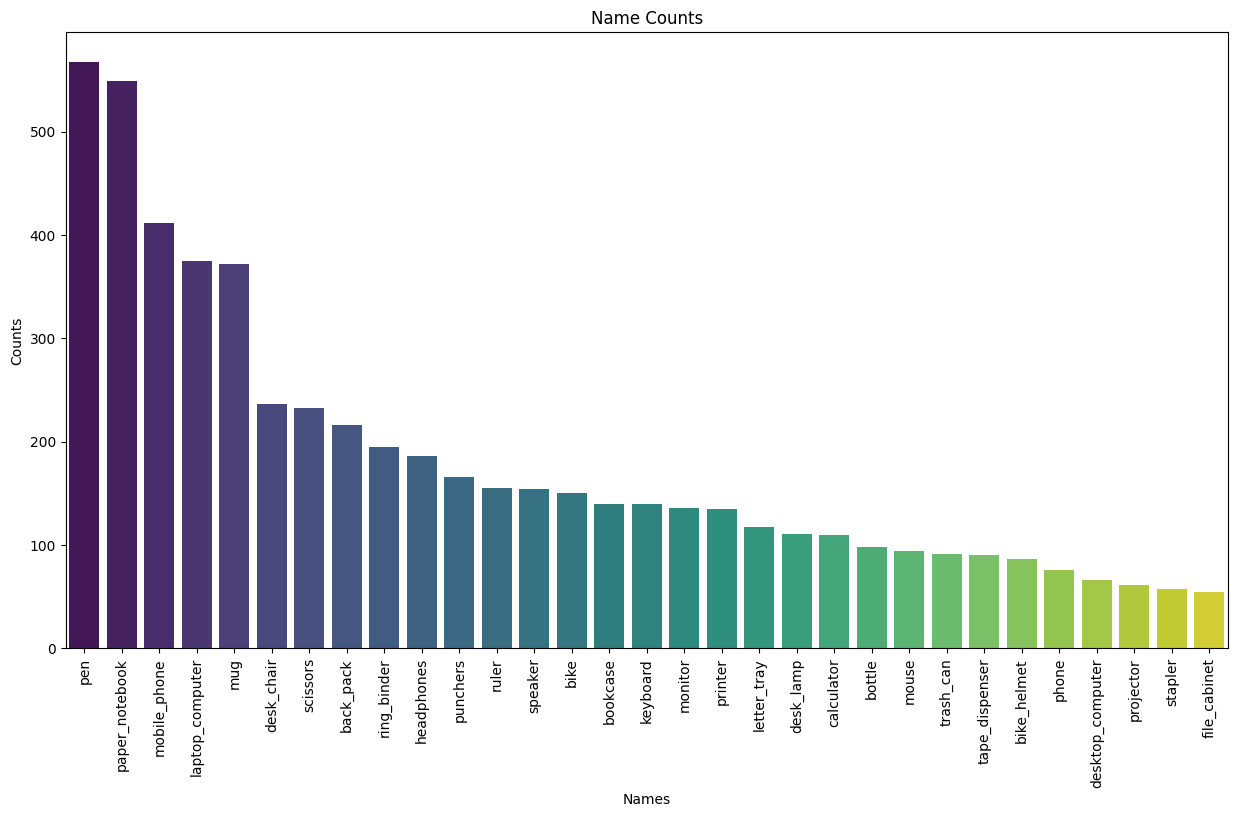

,Name,Count
19,pen,568
18,paper_notebook,549
14,mobile_phone,412
12,laptop_computer,375
17,mug,372
6,desk_chair,236
26,scissors,233
0,back_pack,216
24,ring_binder,195
10,headphones,186


In [21]:
df_count_names2 = print_count_each_names(gether_label_path, is_show_plot=True)
df_count_names2

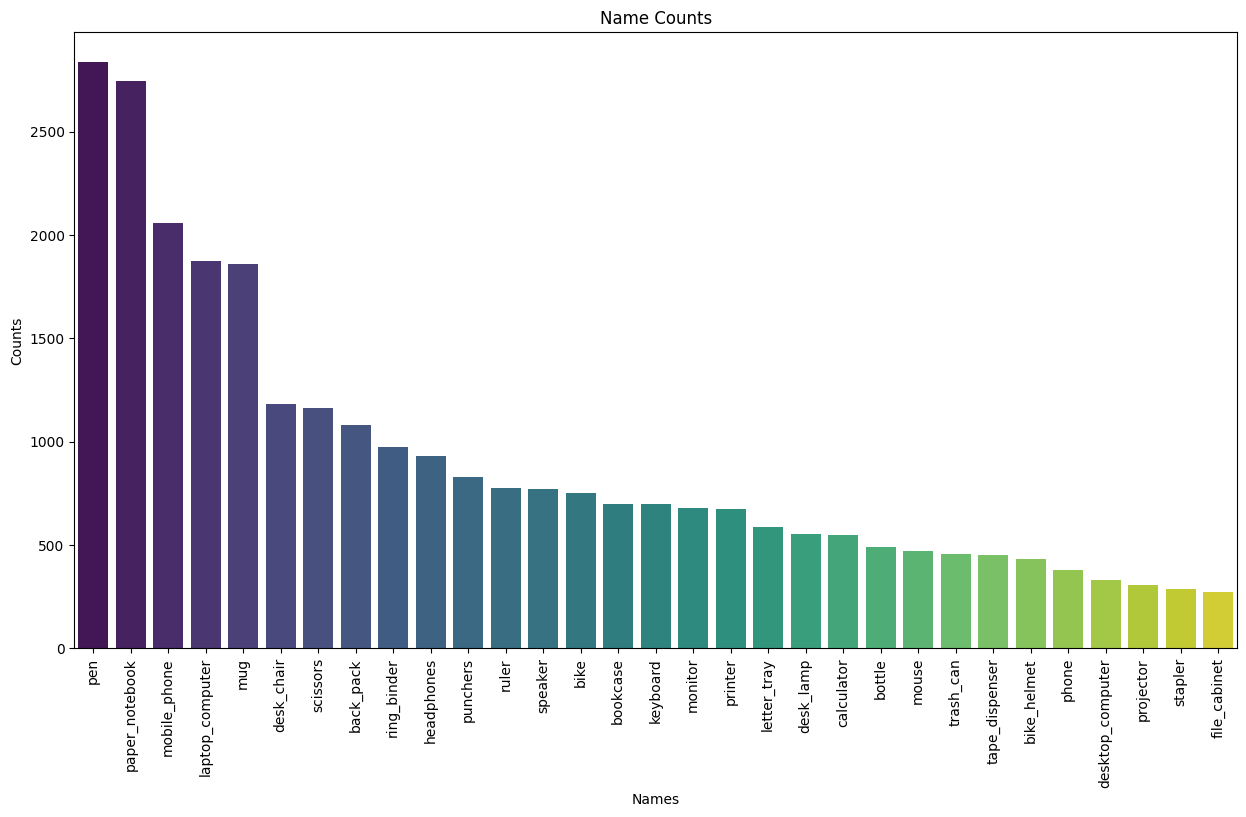

,Name,Count
19,pen,2840
18,paper_notebook,2745
14,mobile_phone,2060
12,laptop_computer,1875
17,mug,1860
6,desk_chair,1180
26,scissors,1165
0,back_pack,1080
24,ring_binder,975
10,headphones,930


In [20]:
df_count_names2 = print_count_each_names(generated2_label_path, is_show_plot=True)
df_count_names2

In [49]:
balance_dataset(generated_path, 810)

Name      pen
Count    2840
Name: 19, dtype: object
2030
Name     paper_notebook
Count              2745
Name: 18, dtype: object
933
Name     mobile_phone
Count            2060
Name: 14, dtype: object
934
Name     laptop_computer
Count               1875
Name: 12, dtype: object
456
Name      mug
Count    1860
Name: 17, dtype: object
427
Name     desk_chair
Count          1180
Name: 6, dtype: object
251
Name     scissors
Count        1165
Name: 26, dtype: object
189
Name     back_pack
Count         1080
Name: 0, dtype: object
244
Name     ring_binder
Count            975
Name: 24, dtype: object
Name     headphones
Count           930
Name: 10, dtype: object
Name     punchers
Count         830
Name: 23, dtype: object


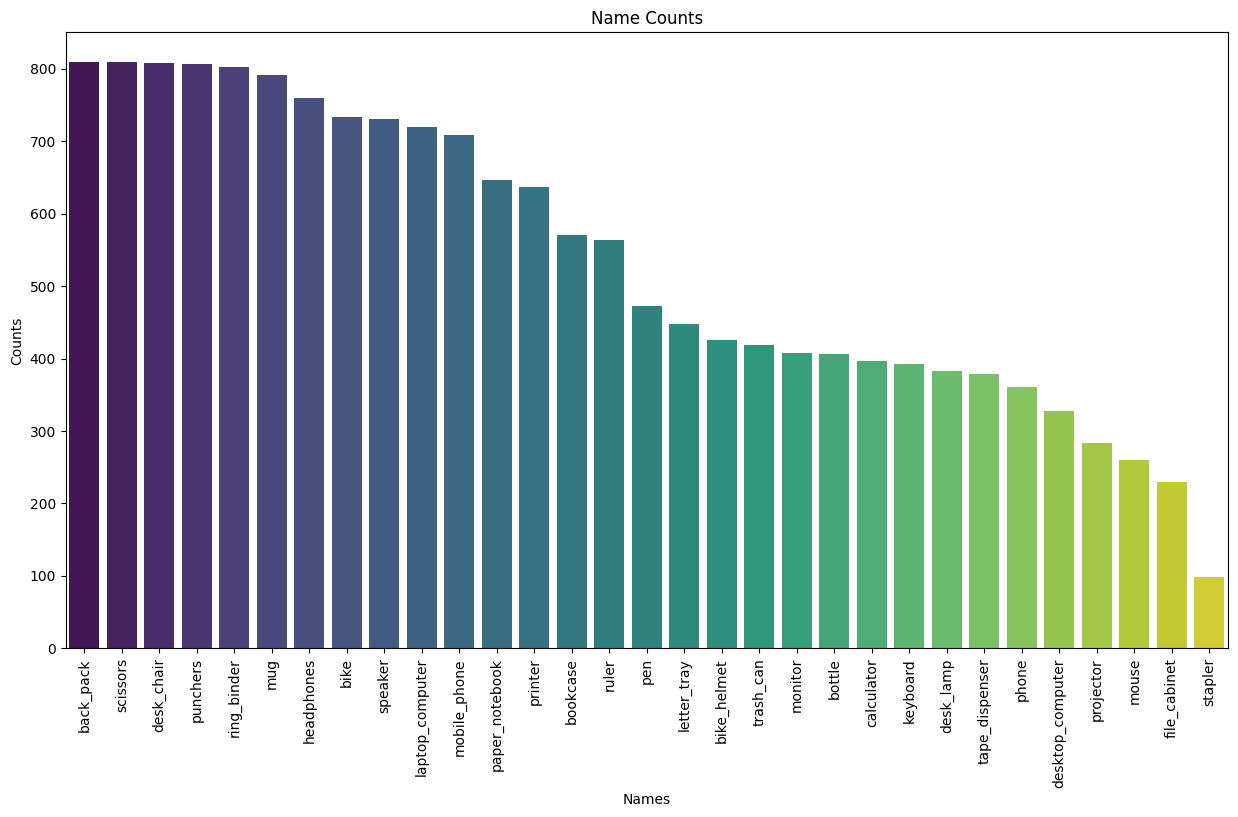

,Name,Count
0,back_pack,810
26,scissors,809
6,desk_chair,808
23,punchers,806
24,ring_binder,803
17,mug,791
10,headphones,759
1,bike,734
27,speaker,731
12,laptop_computer,719


In [50]:
df_count_names = print_count_each_names(generated_label_path, is_show_plot=True)
df_count_names

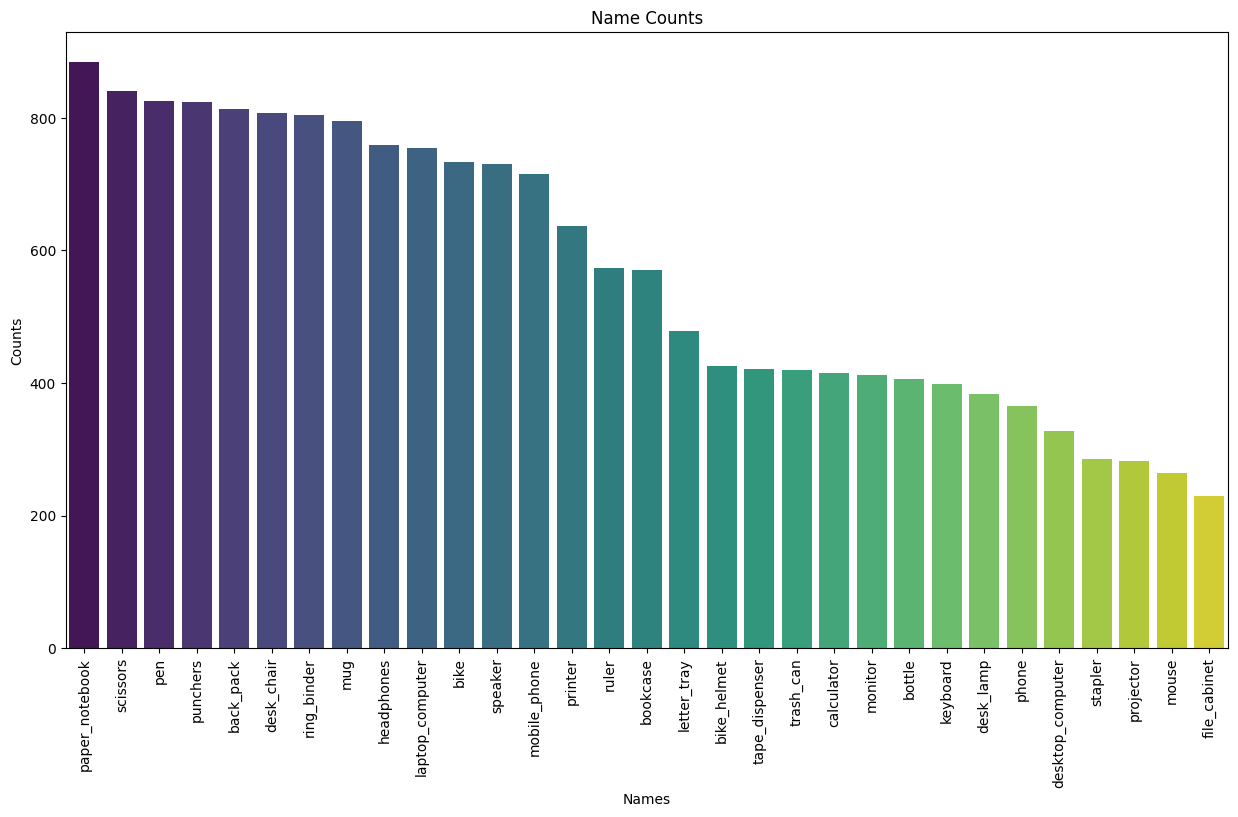

,Name,Count
18,paper_notebook,885
26,scissors,841
19,pen,826
23,punchers,824
0,back_pack,813
6,desk_chair,808
24,ring_binder,805
17,mug,795
10,headphones,759
12,laptop_computer,754


In [52]:
df_count_names = print_count_each_names(generated_label_path, is_show_plot=True)
df_count_names

In [51]:
copy_files_by_class_id(generated2_path, generated_path, ['stapler'])

In [ ]:
# 텍스트 분류 이동

# 분배 비율
ratio_1 = 0.8
ratio_2 = 0.1
ratio_3 = 0.1

# divide_txt_files(gether_label_path,target_train_label_folder, target_test_label_folder, target_valid_label_folder,ratio_1, ratio_2, ratio_3)
divide_txt_files(generated_label_path,target_train_label_folder, target_test_label_folder, target_valid_label_folder,ratio_1, ratio_2, ratio_3)
# 이미지 분류 이동
# 텍스트와 같은 위치로 이동됨
divide_img_files(generated_img_path,target_test_label_folder, target_test_img_folder)
divide_img_files(generated_img_path,target_train_label_folder, target_train_img_folder)
divide_img_files(generated_img_path,target_valid_label_folder, target_valid_img_folder)

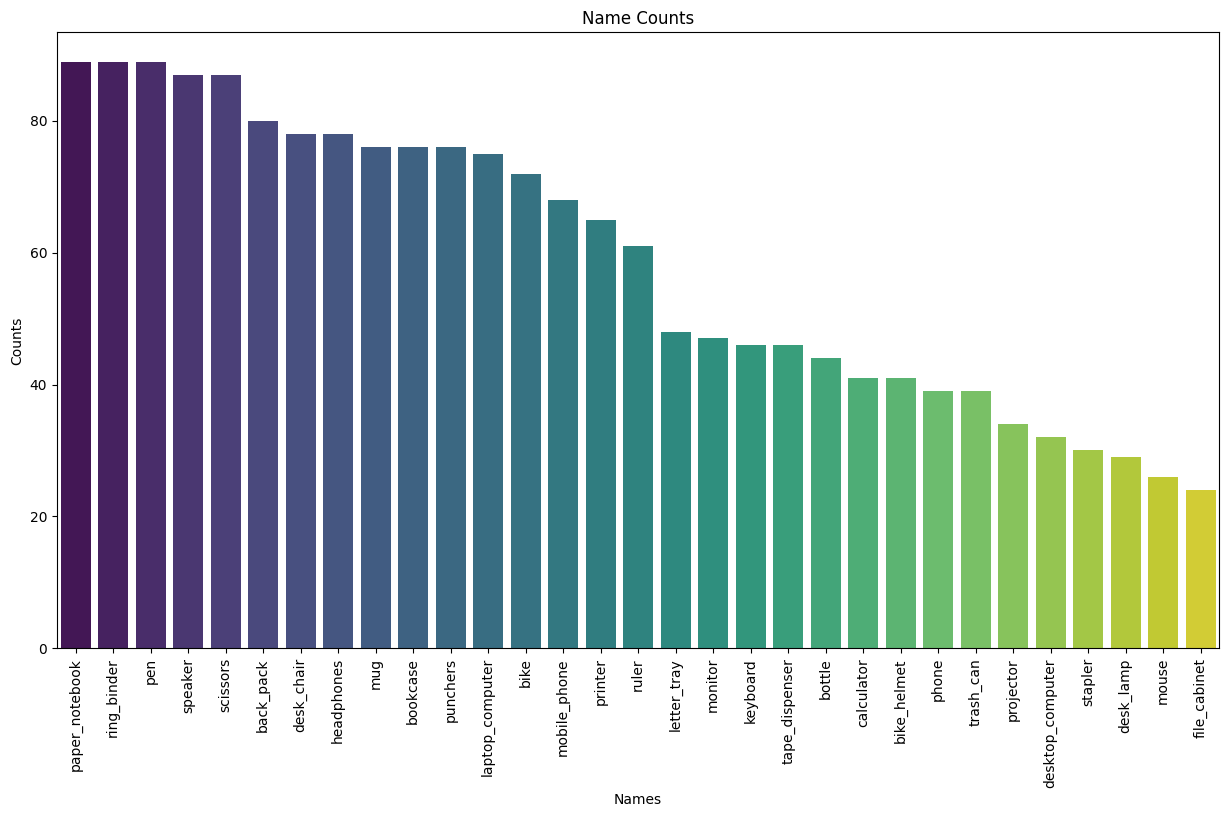

,Name,Count
18,paper_notebook,89
24,ring_binder,89
19,pen,89
27,speaker,87
26,scissors,87
0,back_pack,80
6,desk_chair,78
10,headphones,78
17,mug,76
3,bookcase,76


In [16]:
print_count_each_names(target_test_label_folder, is_show_plot=True)

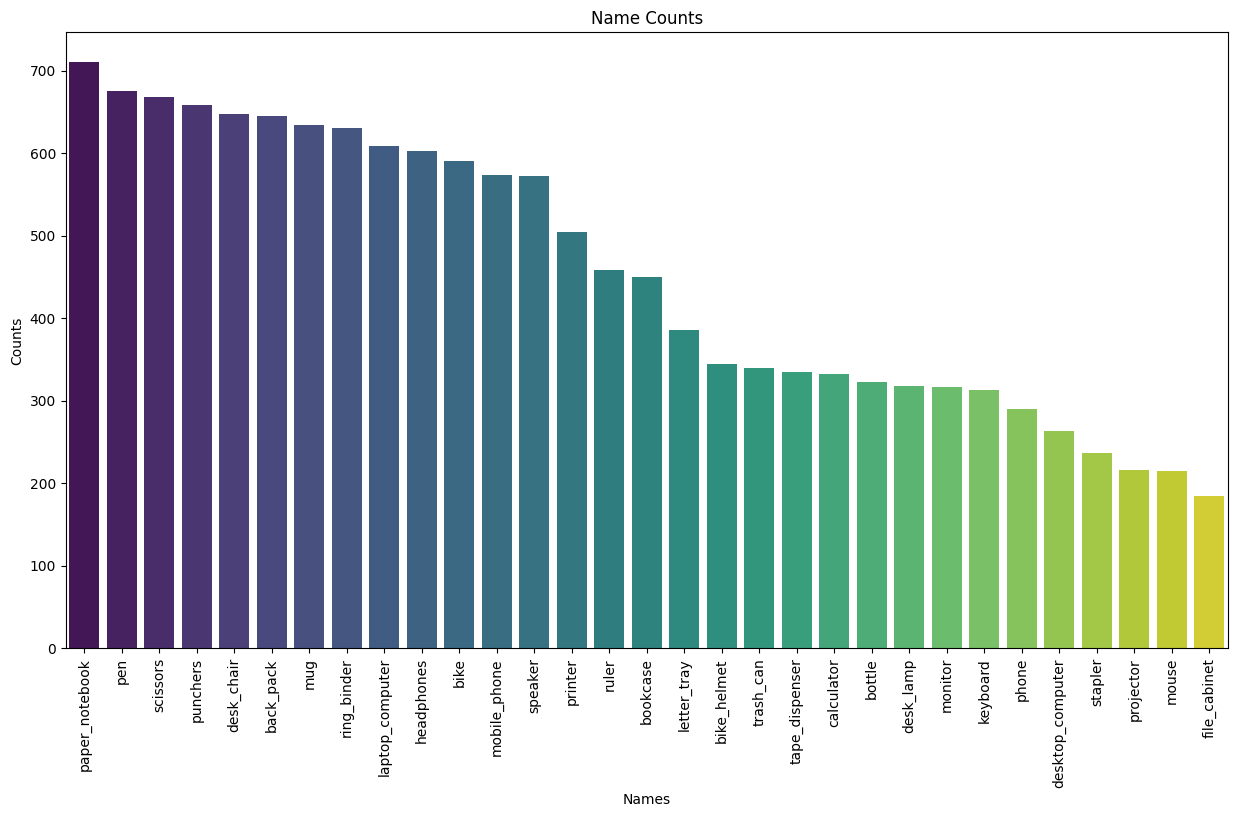

,Name,Count
18,paper_notebook,711
19,pen,675
26,scissors,668
23,punchers,658
6,desk_chair,647
0,back_pack,645
17,mug,634
24,ring_binder,631
12,laptop_computer,609
10,headphones,602


In [17]:
print_count_each_names(target_train_label_folder, is_show_plot=True)

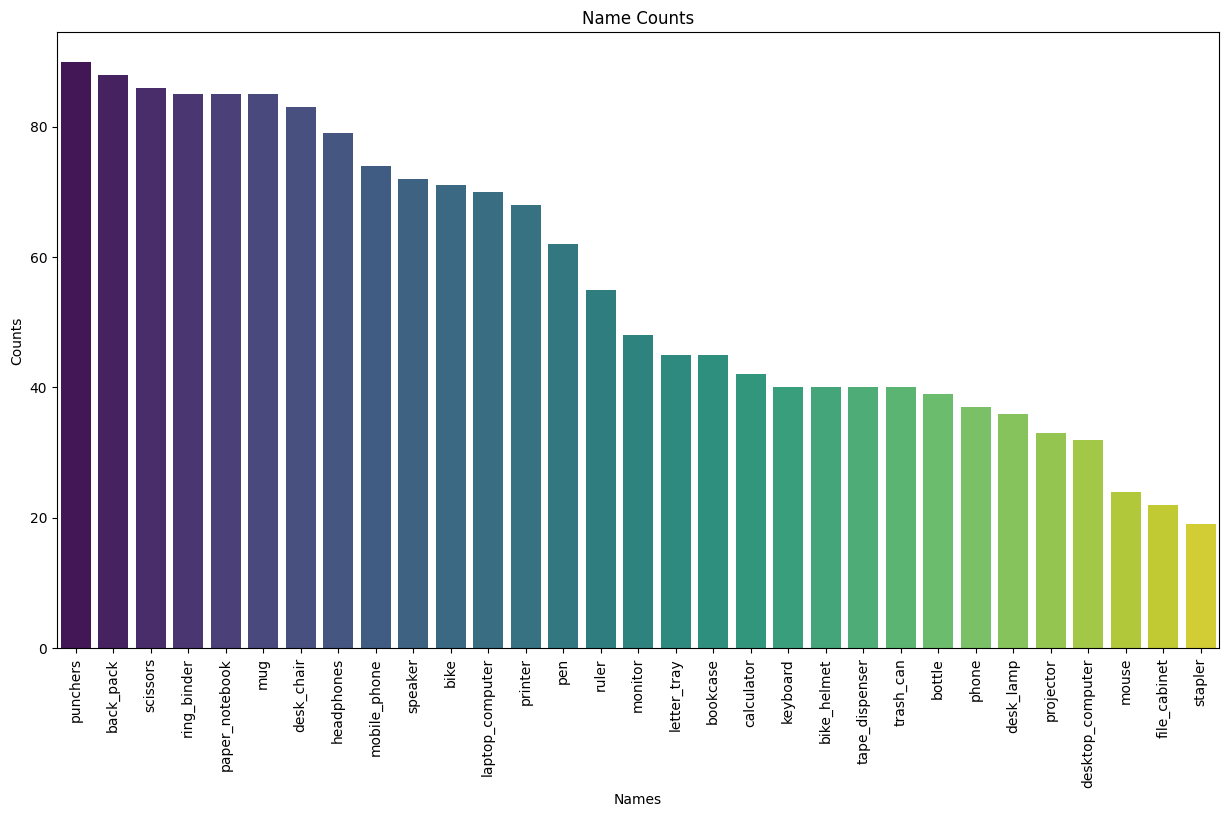

,Name,Count
23,punchers,90
0,back_pack,88
26,scissors,86
24,ring_binder,85
18,paper_notebook,85
17,mug,85
6,desk_chair,83
10,headphones,79
14,mobile_phone,74
27,speaker,72


In [18]:
print_count_each_names(target_valid_label_folder, is_show_plot=True)